Figures for paper

In [162]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy
import matplotlib.ticker as ticker
from matplotlib import animation, gridspec
from matplotlib.gridspec import GridSpec

ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

# 1. Explain Events

2 panels:
- One panel with one member over historical period
    - member 1281.015
    - mean period 1 and period 2
    - 3 std line
- One panel with all members over event period
    - choose nice colors

In [4]:
# Define parameters
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
h = 7
window_size = 40
duration_threshold = 20
threshold_multiple = 3

# Load signal data for the first plot
signals = np.load(raw_files[7])
hist_end = (2014 - 1850) * 12
signals = signals[:hist_end]
time_annual = np.arange(1850, 1850 + (hist_end / 12))

# Read the order file
with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
    vvel_list = file.readlines()
vvel_dict = {int(line.split()[0]): line.split()[1] for line in vvel_list}

# Load data from 'events_dens_spg.csv' to get member numbers
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)
member_numbers = data['Index']

# Process data for the first plot
last_member_name = vvel_dict[member_numbers[-3]][5:]
signal = signals[:, member_numbers[-3]][:hist_end]
annual_mean = np.mean(signal.reshape(-1, 12), axis=1)

# Identify events for the second plot
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
                print(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        writer.writerow({'Index': index, 'Values': values[0]})

# Save event and member names
saved_data = []
for index, values in result:
    file_name = vvel_dict[index][5:-3]
    annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))

sorted_data = sorted(saved_data, key=lambda x: x[0])

120
105
64
141
40
56
55
121
79
41
89
107
57
56


/tmp/ipykernel_198684/2568972952.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 1, 1])


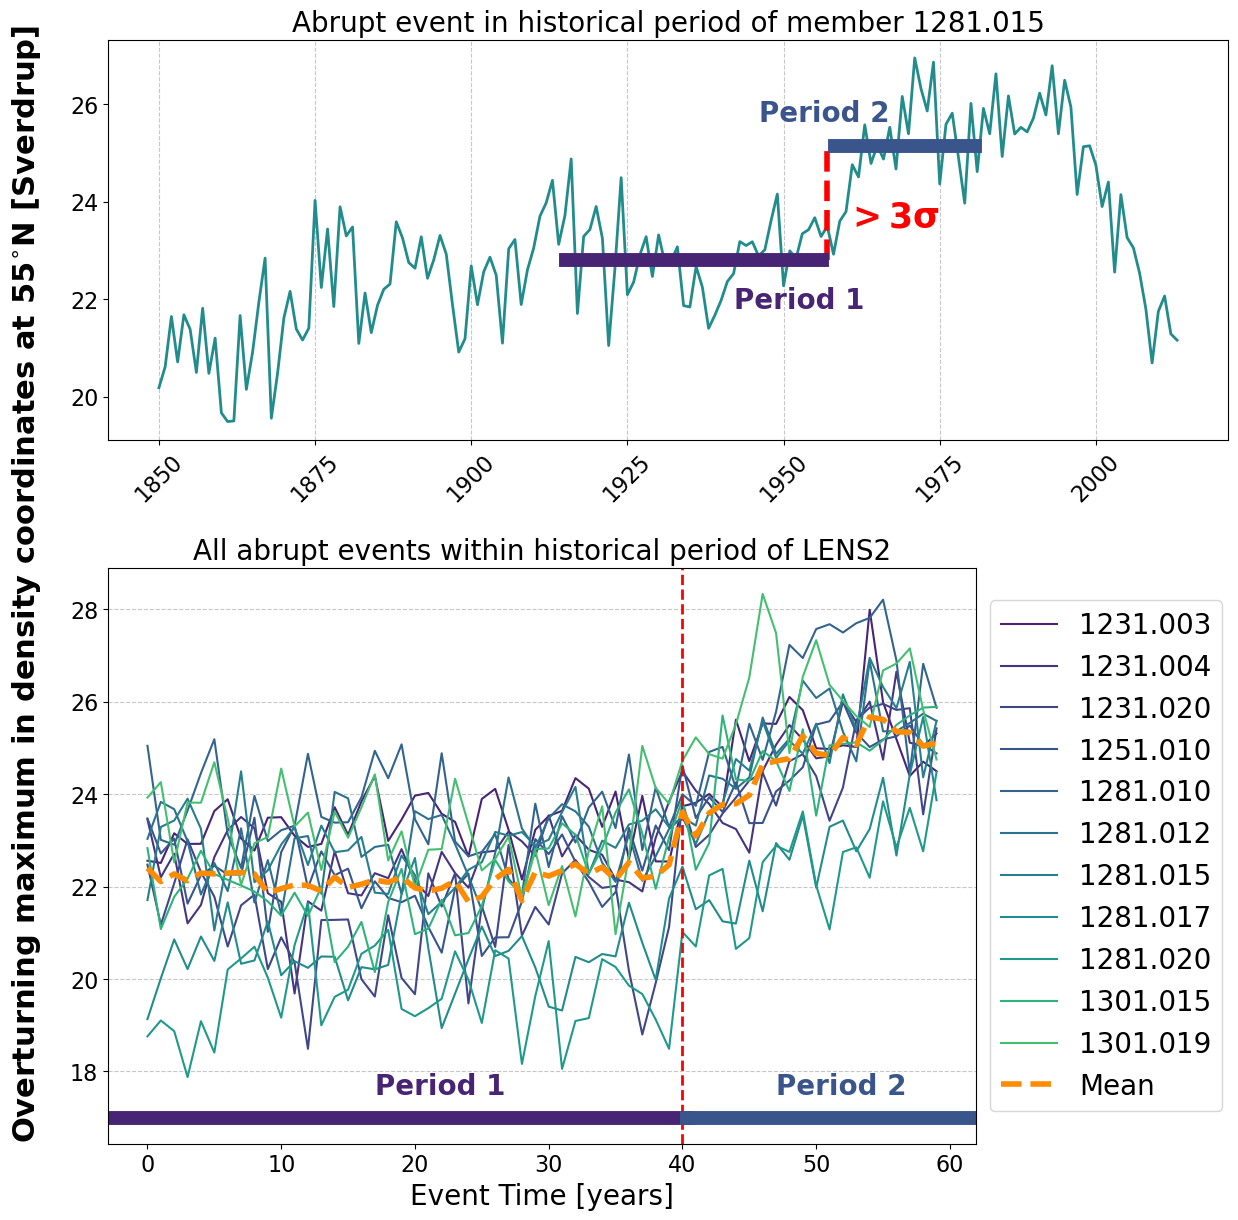

In [8]:
# Create figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 3.2], 'hspace': 0.01})

# Define colormap
colors = cm.viridis(np.linspace(0.1, 0.7, len(sorted_data[1:])))

# Upper subplot
event_location = 107
period_1 = np.mean(annual_mean[event_location - 40: event_location-1])
period_2 = np.mean(annual_mean[event_location+1: event_location + 20])
length = len(annual_mean)

axs[0].plot(time_annual, annual_mean, linewidth=2, color=colors[-5])
axs[0].set_title('Abrupt event in historical period of member ' + last_member_name[:-3], fontsize=20)
axs[0].tick_params(axis='x', labelsize=16, rotation=45)
axs[0].tick_params(axis='y', labelsize=16)
axs[0].locator_params(axis='x', nbins=8)
axs[0].locator_params(axis='y', nbins=5)
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

# Set definition ranges
y_min, y_max = axs[0].get_ylim()
y_length = (y_max - y_min)
vertical_position = 1850+107
axs[0].axvline(x=vertical_position, color='r', linestyle='--', linewidth = 4,
               ymin=(period_1-y_min)/y_length, ymax=(period_2-y_min)/y_length)
axs[0].axhline(y=period_1, color=colors[0], linewidth = 10, 
               xmin=(event_location - 40) / length, xmax=(event_location-2.5) / length)
axs[0].axhline(y=period_2, color=colors[3], linewidth = 10, 
               xmin=(event_location-0.5) / length, xmax=(event_location + 20) / length)

axs[0].text(vertical_position + 3, 0.49 * (period_1 + period_2), r'$\mathbf{> 3 \sigma}$', color='r', fontsize=25)
axs[0].text(vertical_position - 15, 0.455 * (period_1 + period_2), 'Period 1', weight='bold', color=colors[0], fontsize=20)
axs[0].text(vertical_position - 11, 0.535 * (period_1 + period_2), 'Period 2', weight='bold', color=colors[3], fontsize=20)


# Lower subplot
time_series_list = []

for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        axs[1].plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
axs[1].plot(mean_time_series, label='Mean', linestyle='--', color='darkorange', linewidth = 4, zorder=110)

axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
axs[1].set_title(r'All abrupt events within historical period of LENS2', fontsize=20)
axs[1].set_xlabel('Event Time [years]', fontsize=20)
axs[1].tick_params(axis='x', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

event_location = 40
length = 60
axs[1].axvline(x=event_location, color='r', linestyle='--', linewidth = 2)
axs[1].axhline(y=17, color=colors[0], label='Period 1', linewidth = 10, 
               xmin=(event_location - 40) / length, xmax=(event_location) / length)
axs[1].axhline(y=17, color=colors[3], label='Period 2', linewidth = 10, 
               xmin=(event_location) / length, xmax=(event_location + 20) / length)
axs[1].text(17, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=20)
axs[1].text(47, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Adjust positions of subplots
axs[0].set_position([0.1, 0.49, 0.8, 0.25])  # [left, bottom, width, height]
axs[1].set_position([0.1, 0.05, 0.62, 0.36]) 

fig.text(0.03, 0.4, r'Overturning maximum in density coordinates at 55$^{\circ}$N [Sverdrup]', 
         weight='bold', va='center', rotation='vertical', fontsize=22)

# Align the left edges of both subplots
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Figure_1.png', bbox_inches='tight', dpi=300)

# 2. Denisty Stream Function Anomaly

- Heatmap of density streamfunction anomaly
- Contours of period 1
- Y-axis scaled to volume per layer


    1. **Calculate volume per layer**:

       $
       V_i = dz_i \times UAREA
       $

    where $i$ denotes the layer index.

    2. **Aggregate densities along z**:

       - Convert the 2D density array into a 1D array by averaging along the z-axis.


    3. **Classify volumes by density**:
       - Define density classes (bins), e.g., $ \rho_1, \rho_2, \ldots, \rho_n $.
       - For each layer $ i $, find the density class $ \rho_k $ where $ \bar{\rho_i} $ belongs.
       - Sum the volumes of layers for each density class:

       $
       V_{\rho_k} = \sum_{i \in \text{class} \, k} V_i
       $



In [3]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
anom_smoc_ds = xr.open_dataset(smoc_file)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
### scale y-axis ###

ds_sig = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SIGMA_2composite.nc')

grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask3d = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
mask3d = mask3d.sum('region')

ds_sig = ds_sig.roll(nlon=+100).where(mask3d)
ds_sig = ds_sig.roll(nlon=-100)

In [ ]:
ds_vol = xr.open_dataset(temp_file).isel(time=0)
ds_vol = ds_vol.roll(nlon=+100).where(mask3d)
ds_vol = ds_vol.roll(nlon=-100)

In [9]:
# compute volume per layer 
volume_per_layer = (ds_vol['dz'] * ds_vol['UAREA']).mean(dim=('nlat', 'nlon')).values

# average density per grid volume
density_per_layer = ds_sig.SIGMA_2.mean(dim=('time', 'nlat', 'nlon')).values

density_classes = np.array([32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 
                            35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.3, 36.4, 
                            36.46, 36.54, 36.6, 36.65, 36.69, 36.73, 36.75, 36.78, 36.82, 36.84, 36.86, 
                            36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37.,])

# Classify average densities into density classes
density_class_indices = np.digitize(density_per_layer, bins=density_classes)

# Sum the volumes for each density class
volume_per_density_bin = np.zeros(len(density_classes) - 1)
for i in range(len(density_classes) - 1):
    volume_per_density_bin[i] = np.sum(volume_per_layer[i:i+2])
    

# Scale the y-axis (density) using the volume per density bin
# Compute the midpoints of density classes for plotting
density_midpoints = (density_classes[:-1] + density_classes[1:]) / 2

# Convert density values to indices of the volume per density bin
density_indices = np.digitize(density_midpoints, bins=density_classes) - 1

# Scale the y-axis (density) using the volume per density bin
# Compute the midpoints of density classes for plotting
density_midpoints = (density_classes[:-1] + density_classes[1:]) / 2

# Convert density values to indices of the volume per density bin
density_indices = np.digitize(density_midpoints, bins=density_classes) - 1

In [16]:
y_axis = np.arange(density_classes.shape[0])

TypeError: Dimensions of C (117, 115) should be one smaller than X(115) and Y(45) while using shading='flat' see help(pcolormesh)

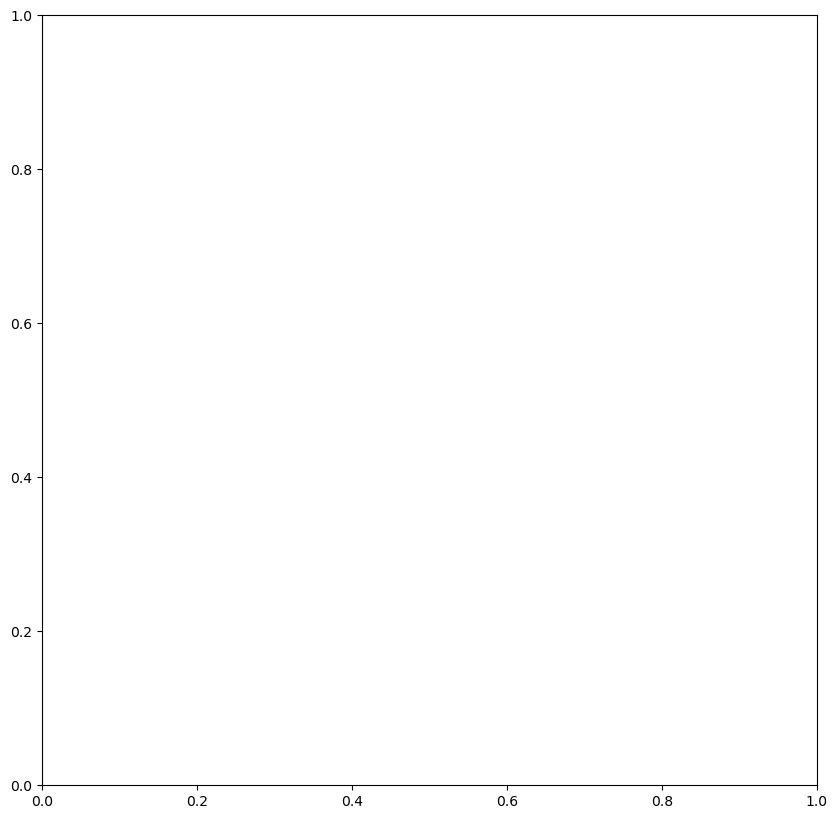

In [17]:

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), y_axis, anom_smoc_ds.densMOC,
                   cmap=cmo.balance)

plt.show()

IndexError: tuple index out of range

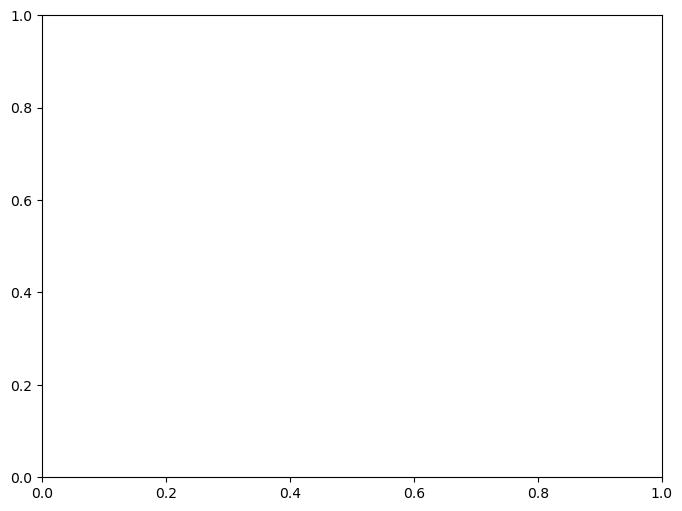

In [11]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(ds_ps.TLAT.isel(nlat=slice(250, 365)), len(density_classes), anom_smoc_ds.densMOC, cmap='viridis')
plt.colorbar(label='Data')
plt.ylabel('Density')
#plt.yticks(density_midpoints, [f"{density_classes[i]}-{density_classes[i+1]}" for i in range(len(density_classes) - 1)])
plt.xlabel('Latitude')
plt.title('2D Data Array with Scaled Y-Axis')
plt.grid(False)
plt.show()

In [15]:
vmin = -12.5
vmax = -vmin

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

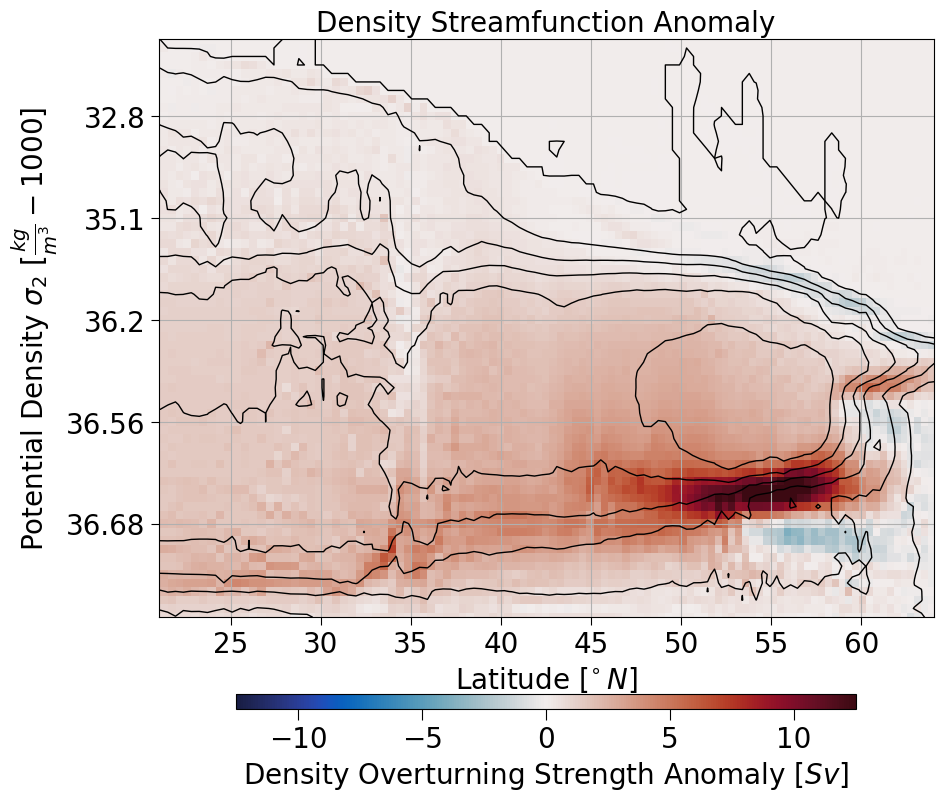

In [16]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, anom_smoc_ds.densMOC,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + 'Figure_2.png', bbox_inches='tight', dpi=300)

In [ ]:
import numpy as np
import xarray as xr

# Assuming 'ds' is your dataset and 'density_classes' is your 1D array for density class borders
# 'mean_density_per_layer' is the average density per layer (computed previously)
# 'mean_volume_per_layer' is the volume per layer (computed previously)

# Example density classes (borders)
density_classes = np.array([20, 22, 24, 26, 28, 30])

# Classify average densities into density classes
density_class_indices = np.digitize(mean_density_per_layer, bins=density_classes)

# Initialize an array to store the volume per density class
volume_per_density_class = np.zeros(len(density_classes) + 1)

# Sum the volumes for each density class
for i, class_index in enumerate(density_class_indices):
    volume_per_density_class[class_index] += mean_volume_per_layer[i]

# Output the volume per density class
for i in range(len(density_classes) + 1):
    if i == 0:
        print(f"Volume for density < {density_classes[0]}: {volume_per_density_class[i]}")
    elif i == len(density_classes):
        print(f"Volume for density >= {density_classes[-1]}: {volume_per_density_class[i]}")
    else:
        print(f"Volume for {density_classes[i-1]} <= density < {density_classes[i]}: {volume_per_density_class[i]}")

# 3. Convection Anomaly

# 4. Flip books

In [128]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
maskBSF = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
maskBSF = maskBSF.sum('region')  

In [155]:
variables = ['TEMP', 'SALT', 'SIGMA_2']
labels = [r'Temperature Anomaly over the first 100 metres (Period 1 - Period 2)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over the first 100 metres (Period 1 - Period 2)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over the first 100 metres (Period 1 - Period 2) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]

In [ ]:
files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

datasets = {var: xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100) for var in variables}
replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

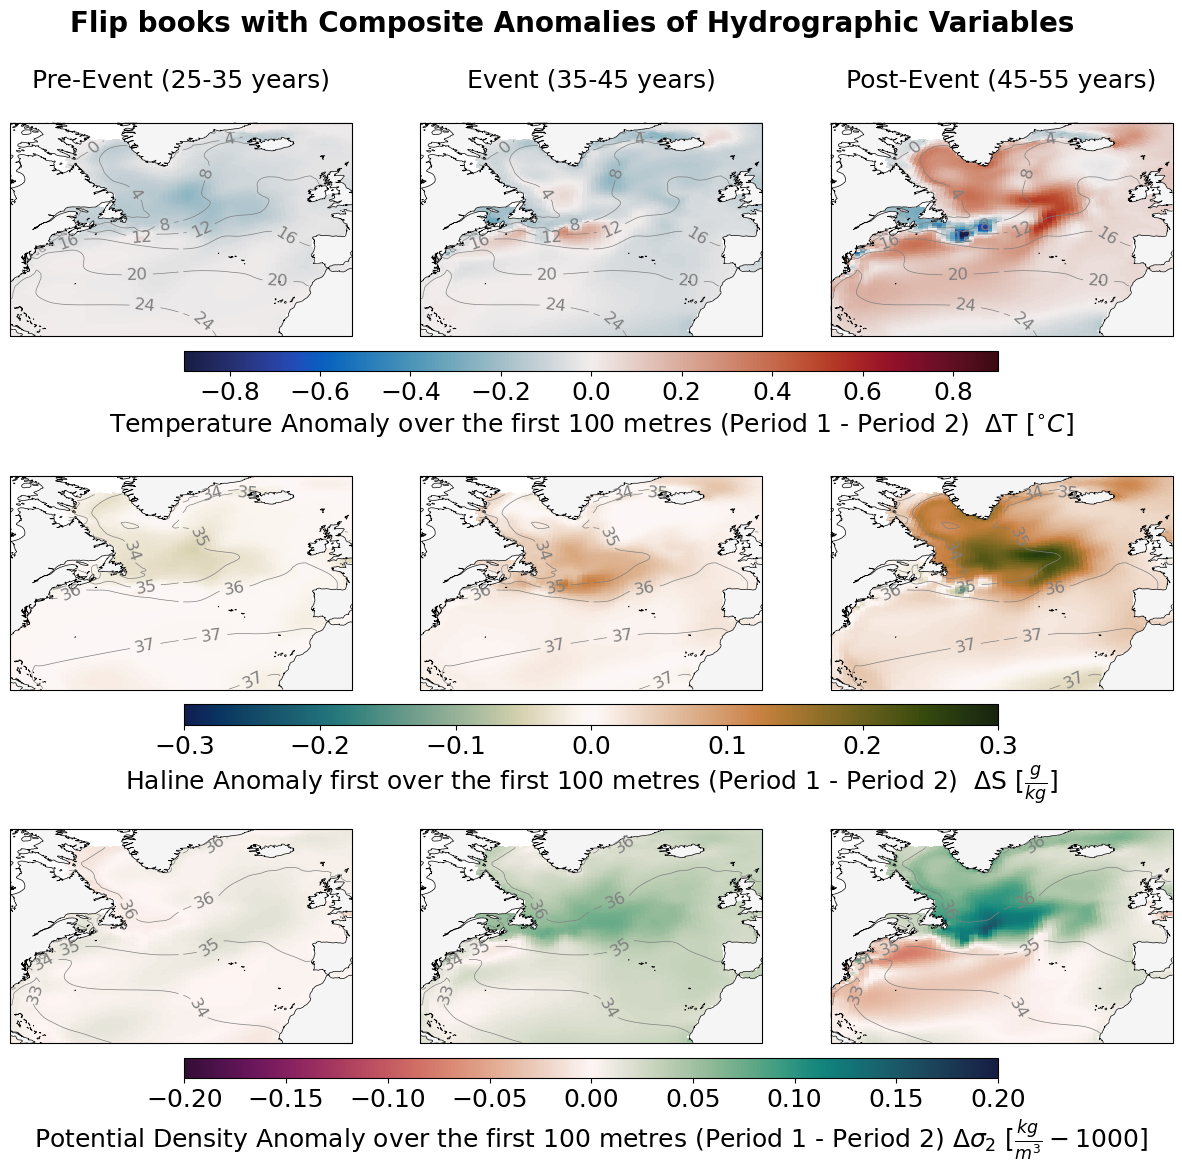

In [164]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle('Flip books with Composite Anomalies of Hydrographic Variables', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Figure_4.png', bbox_inches='tight', dpi=300)